<a href="https://colab.research.google.com/github/Vishy-A/CPPCompEngProgramming/blob/main/HW7/4105HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np
import pandas as pd
import torch
%matplotlib inline
import torch.nn as nn
import collections
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from collections import OrderedDict
from google.colab import drive
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
torch.set_printoptions(edgeitems = 2)
torch.manual_seed(123)


from torchvision import datasets
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train = True, download = True)
cifar10_val = datasets.CIFAR10(data_path, train = False, download = True)

Files already downloaded and verified
Files already downloaded and verified


In [40]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [41]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [42]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [43]:

label_map = {0: 0, 10: 1}

cifar10 = [(img, label_map[label])
            for img, label in cifar10
            if label in [0, 10]]
cifar10_val = [(img, label_map[label])
                for img, label in cifar10_val
               if label in [0, 10]]

In [44]:
 model = nn.Sequential(
 nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [45]:
numel_list = [p.numel()
              for p in model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [46]:
conv = nn.Conv2d(3, 16, kernel_size=3) # <1>
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [47]:
img, _ = cifar10[0]

output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

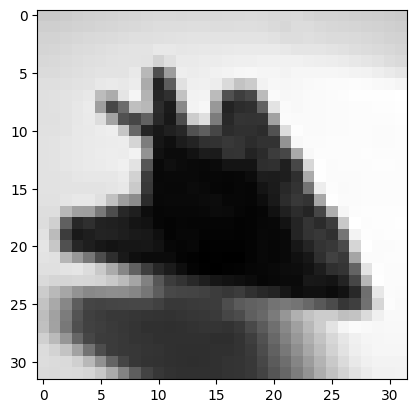

In [48]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

In [49]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # <1>
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [50]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

In [51]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

In [52]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [53]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            )

In [54]:
import torch.nn.functional as F

class network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [55]:
model = network()
model(img.unsqueeze(0))

tensor([[ 0.0413, -0.1156]], grad_fn=<AddmmBackward0>)

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

In [56]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [61]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)

model = network()
optimizer = optim.SGD(model.parameters(), lr=.0001)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-12-13 04:10:18.071609 Epoch 1, Training loss 0.7269678666621824
2023-12-13 04:10:33.838424 Epoch 10, Training loss 0.5163885287091702
2023-12-13 04:10:49.399300 Epoch 20, Training loss 0.3315616604648059
2023-12-13 04:11:04.674837 Epoch 30, Training loss 0.21324442194986948
2023-12-13 04:11:20.081024 Epoch 40, Training loss 0.14581837212737603
2023-12-13 04:11:35.282351 Epoch 50, Training loss 0.10687109309283993
2023-12-13 04:11:50.583501 Epoch 60, Training loss 0.08208418477185164
2023-12-13 04:12:05.821852 Epoch 70, Training loss 0.06617042757099188
2023-12-13 04:12:21.129509 Epoch 80, Training loss 0.05468500400834446
2023-12-13 04:12:36.088804 Epoch 90, Training loss 0.04638427425223061
2023-12-13 04:12:51.074738 Epoch 100, Training loss 0.04015632129356831
2023-12-13 04:13:06.041841 Epoch 110, Training loss 0.035305495480004744
2023-12-13 04:13:21.184302 Epoch 120, Training loss 0.0314427213861218
2023-12-13 04:13:36.733992 Epoch 130, Training loss 0.02821148382617703
2023-1

In [62]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 1.00
